## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

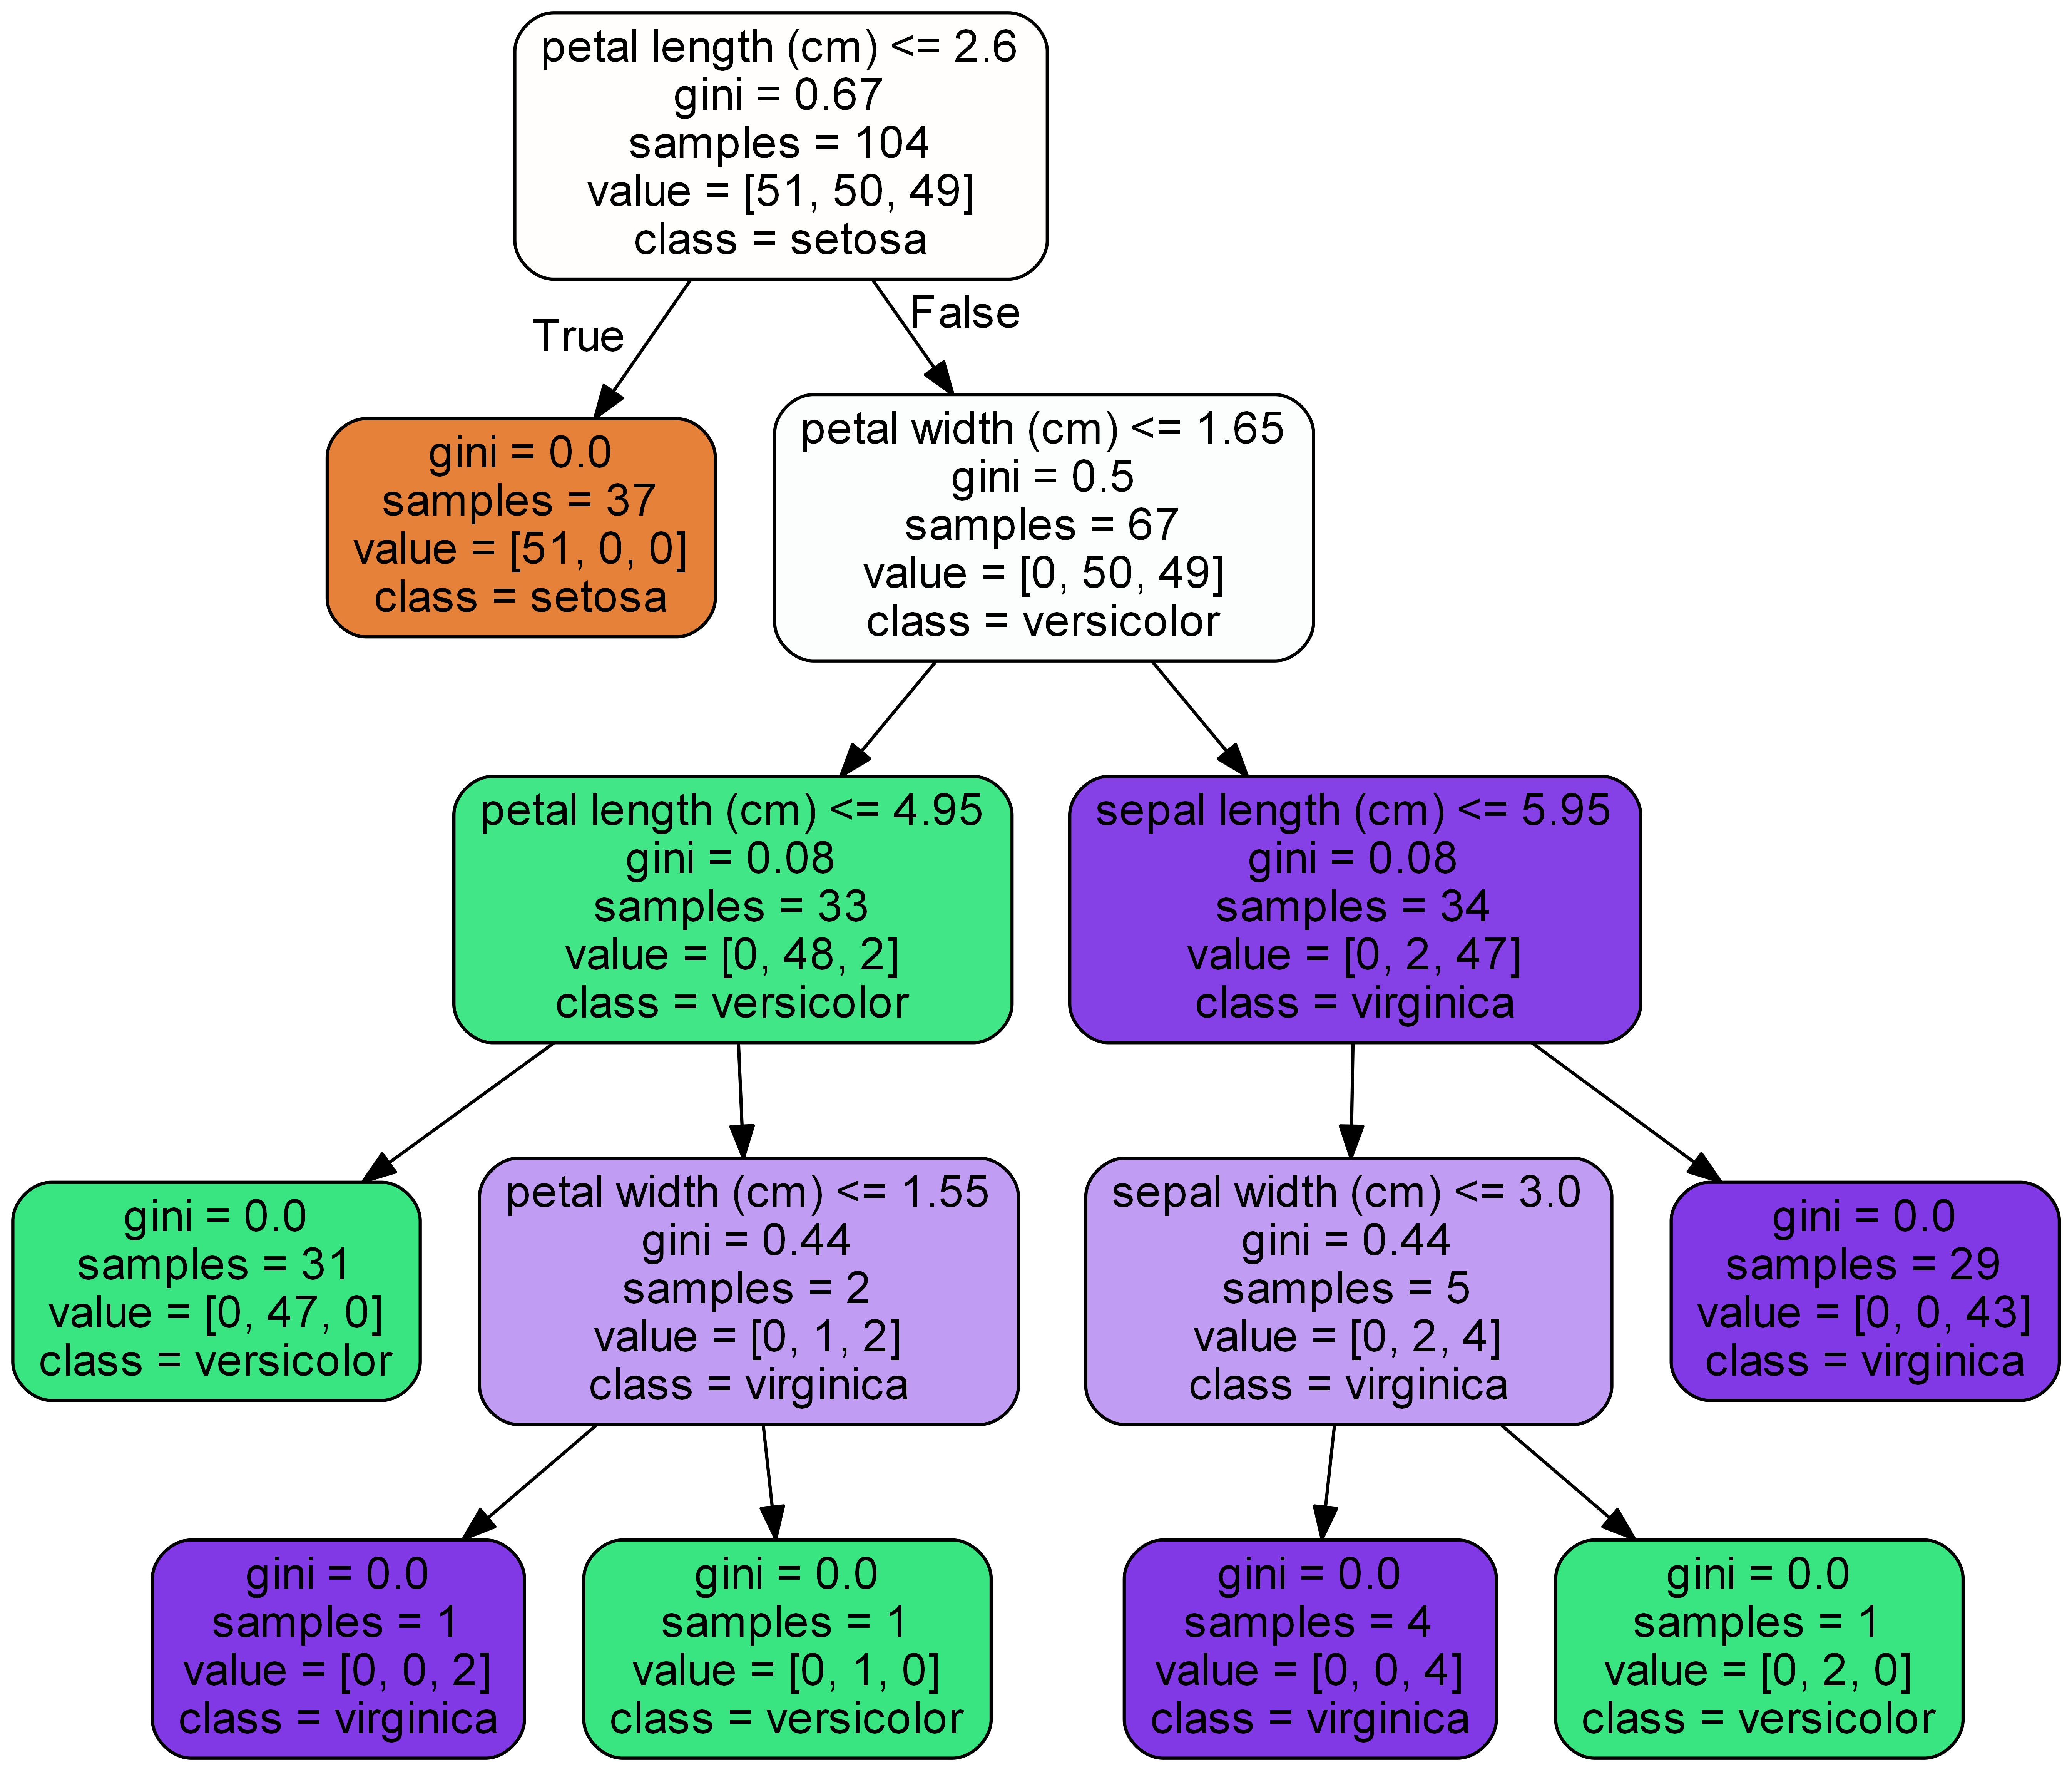

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
!dot -Tpng tree.dot -o tree.png -Gdpi=600

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
import zipfile
import math
import random

In [3]:
with zipfile.ZipFile('SouthKoreacoronavirusdataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
df = pd.read_csv('SouthKoreacoronavirusdataset\PatientInfo.csv')
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [5]:
df.shape

(2218, 18)

In [6]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [7]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [8]:
df['n_age'] = datetime.today().year - df['birth_year']

In [9]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,58.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,35.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,58.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,31.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,30.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [10]:
#df.isna().sum()
pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Missing'])

,Missing
disease,2199
deceased_date,2186
infection_order,2176
symptom_onset_date,2025
released_date,1995
contact_number,1807
infected_by,1749
infection_case,1055
global_num,904
n_age,454


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [12]:
df['disease'].fillna(0, inplace=True)
df['disease'].loc[df['disease']==True] = 1

C:\Users\pablo\AppData\Local\Temp/ipykernel_19228/3927744667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disease'].loc[df['disease']==True] = 1


 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [13]:
feats = ['global_num','birth_year','infection_order','infected_by', 'contact_number']
_ = [df[f].fillna(df[f].mean(), inplace=True) for f in feats]

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [14]:
pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Missing'])

,Missing
deceased_date,2186
symptom_onset_date,2025
released_date,1995
infection_case,1055
n_age,454
age,261
sex,145
confirmed_date,141
state,88
city,65


### `state` Column Analysis

Since there are only 88 values missing in `state` column. We think it is better to drop those instead of adding a new 'missing' feature since this can be misleading and decrease the prediction accuracy of the model implemented

In [15]:
#Dropping observations with null 'state' column values and applying it to dataframe to keep dimensions for modeling
df = df.loc[df['state'].notnull()]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2130 non-null   int64  
 1   global_num          2130 non-null   float64
 2   sex                 1985 non-null   object 
 3   birth_year          2130 non-null   float64
 4   age                 1956 non-null   object 
 5   country             2130 non-null   object 
 6   province            2130 non-null   object 
 7   city                2065 non-null   object 
 8   disease             2130 non-null   object 
 9   infection_case      1076 non-null   object 
 10  infection_order     2130 non-null   float64
 11  infected_by         2130 non-null   float64
 12  contact_number      2130 non-null   float64
 13  symptom_onset_date  187 non-null    object 
 14  confirmed_date      1989 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

### `sex` Column Analysis

In [17]:
df['sex'].unique()

array(['male', 'female', nan], dtype=object)

In [18]:
#Filling null values in 'sex' column with 'unknown' string
df['sex'].fillna('unknown', inplace=True)

### `n_age` Column Analysis

For this feature, we can leverage `age` column so we can have a hint on at least what decade the observation belongs to. For that reason, we will check the observations where `n_age` is null but `age` is not. Then, we will take the decade and then impute 5 years after the decade as the estimated age. For instance, if the decade in `age` is found to be 5, then we will impute 55 to observation `n_age` column value.

In [19]:
#Filling null values in 'age' column with '-' string for simplicity of operation
df['age'].fillna('-999', inplace=True)

In [20]:
df['n_age'] = df.apply(
    lambda row: (int(row['age'][:-1])+5) if np.isnan(row['n_age']) else row['n_age'],
    axis=1
)

In [21]:
df['age'].unique()

array(['50s', '30s', '20s', '60s', '80s', '70s', '40s', '10s', '90s',
       '0s', '-999', '100s'], dtype=object)

In [22]:
df['n_age'].unique()

array([ 58.,  35.,  31.,  30.,  56.,  27.,  39.,  62.,  60.,  84.,  70.,
        79.,  77.,  78.,  22.,  81.,  86.,  37.,  61.,  42.,  64.,  36.,
        54.,  72.,  68.,  57.,  52.,  38.,  59.,  46.,  69.,  45.,  43.,
        23.,  29.,  66.,  28.,  49.,  85.,  76.,  32.,  87.,  67.,  48.,
        47.,  55.,  40.,  19.,  26.,  34.,  71.,  25.,  17.,  53.,  50.,
        51.,  93.,   9.,  41.,   2.,  33.,  44.,  24.,  63.,  73.,  15.,
        18.,  21.,  10.,  83.,  16.,  20.,  75.,   7.,  90.,  74.,  65.,
        88.,  92.,  89.,  13.,   4.,  80.,  14.,  11., -94.,   5.,   8.,
         3.,  82.,  96.,  12.,  97.,  94.,  95., 106.,  91.])

In [23]:
#Sanity check
len(df['age'][df['age'].notna()])

2130

In [24]:
#Sanity check
len(df['n_age'][df['n_age'].notna()])

2130

In [25]:
df['n_age'][df['n_age']!=-94].value_counts()

25.0     122
55.0      88
45.0      71
35.0      54
65.0      51
        ... 
94.0       2
12.0       1
97.0       1
106.0      1
91.0       1
Name: n_age, Length: 96, dtype: int64

Continuing with out feature analysis:

In [26]:
df['n_age'][df['n_age']!=-94].describe()

count    1979.000000
mean       46.683173
std        19.431823
min         2.000000
25%        29.000000
50%        46.000000
75%        60.000000
max       106.000000
Name: n_age, dtype: float64

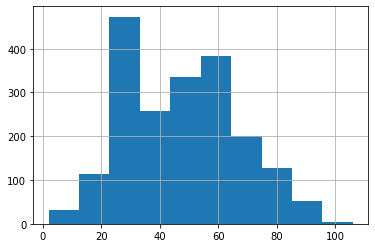

In [27]:
_ = df['n_age'][df['n_age']!=-94].hist()

In 2020, __71.67%__ of South Korea population were between 15 and 64 according to this [link.](https://www.statista.com/statistics/242558/age-distribution-in-south-korea/#:~:text=Age%20distribution%20in%20South%20Korea%202020&text=In%20South%20Korea%2C%20approximately%2071.67,made%20up%20around%2015.8%20percent.)

In [28]:
#Let's see how close this distribution is resembled with the data we have
between_15_64 = df['n_age'][df['n_age']!=-94].loc[np.logical_and(df['n_age']>=15, df['n_age']<=64)]
#Ratio of age distribution
len(between_15_64)/len(df['n_age'][df['n_age']!=-94]) * 100

78.6255684689237

The data is similar! Now, let's see if imputing missing values with the mean keep the distribution close to 71.67%

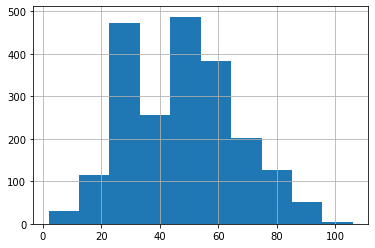

In [29]:
#Filling null values in 'n_age' column with the mean on ages registered in the study
impval = int(np.mean(df['n_age'][df['n_age']!=-94]))
df['temp'] = df.apply(
    lambda row: impval if row['n_age'] == -94 else row['n_age'],
    axis=1
)
_ = df['temp'].hist()

In [30]:
#Let's see how close this distribution is resembled with the data we have after mean imputation
between_15_64_mean = df['temp'].loc[np.logical_and(df['temp']>=15, df['temp']<=64)]
#Ratio of age distribution after mean imputation
len(between_15_64_mean)/len(df['temp']) * 100

80.14084507042254

In this case mean and median are equivalent, so we can try with the mode:

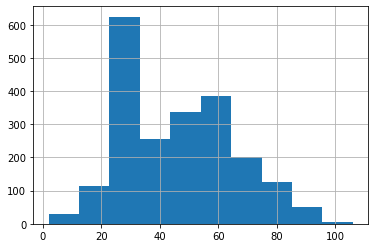

In [31]:
#Filling null values in 'n_age' column with the mean on ages registered in the study
impval = int(df['n_age'][df['n_age']!=-94].mode())
df['temp'] = df.apply(
    lambda row: impval if row['n_age'] == -94 else row['n_age'],
    axis=1
)
_ = df['temp'].hist()

In [32]:
#Let's see how close this distribution is resembled with the data we have after mean imputation
between_15_64_mode = df['temp'].loc[np.logical_and(df['temp']>=15, df['temp']<=64)]
#Ratio of age distribution after mean imputation
len(between_15_64_mode)/len(df['temp']) * 100

80.14084507042254

Imputing with mean, median and mode give us 80.14%. Which is higher than our true value of 71.67% in the age distribution between 15 and 64. Therefore, we decided to impute the age placing random numbers between 2 and 80 years to see if we can get closer to the true value:

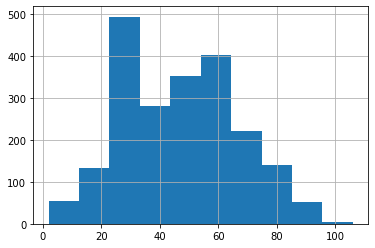

In [33]:
#Filling null values in 'n_age' column with the mean on ages registered in the study
df['temp'] = df.apply(
    lambda row: random.randint(2, 80) if row['n_age'] == -94 else row['n_age'],
    axis=1
)
_ = df['temp'].hist()

In [34]:
#Let's see how close this distribution is resembled with the data we have after mean imputation
between_15_64_rand = df['temp'].loc[np.logical_and(df['temp']>=15, df['temp']<=64)]
#Ratio of age distribution after mean imputation
len(between_15_64_rand)/len(df['temp']) * 100

77.41784037558685

A little bit higher than 71.67% but not that far. We can go with this imputation.

In [35]:
#Filling null values in 'n_age' column with random numbers on ages registered in the study according to the distribution
df['n_age'] = df.apply(
    lambda row: random.randint(2, 80) if row['n_age'] == -94 else row['n_age'],
    axis=1
)
#Dropping temporary column
df.drop(columns=['temp'], inplace=True)

In [36]:
df['n_age'].unique()

array([ 58.,  35.,  31.,  30.,  56.,  27.,  39.,  62.,  60.,  84.,  70.,
        79.,  77.,  78.,  22.,  81.,  86.,  37.,  61.,  42.,  64.,  36.,
        54.,  72.,  68.,  57.,  52.,  38.,  59.,  46.,  69.,  45.,  43.,
        23.,  29.,  66.,  28.,  49.,  85.,  76.,  32.,  87.,  67.,  48.,
        47.,  55.,  40.,  19.,  26.,  34.,  71.,  25.,  17.,  53.,  50.,
        51.,  93.,   9.,  41.,   2.,  33.,  44.,  24.,  63.,  73.,  15.,
        18.,  21.,  10.,  83.,  16.,  20.,  75.,   7.,  90.,  74.,  65.,
        88.,  92.,  89.,  13.,   4.,  80.,  14.,  11.,   3.,   5.,   8.,
        82.,  96.,  12.,  97.,  94.,  95., 106.,  91.,   6.])

In [37]:
df['n_age'].value_counts()

25.0     125
55.0      91
45.0      74
27.0      56
65.0      55
        ... 
96.0       2
94.0       2
97.0       1
106.0      1
91.0       1
Name: n_age, Length: 97, dtype: int64

So the age processing and imputation is done. However, there is one __caveat here: we are considering keeping the same distribution of Korean population (overall) same as Korean COVID Patients Registered Population (sample). Therefore, it could be some sideeffects using this kind of imputation since the two of those populations are not quite the same.__

### `city` Column Analysis

In [38]:
len(df['city'].unique())

134

In [39]:
df['city'].value_counts()/len(df['city']) * 100

Gyeongsan-si    25.117371
Cheonan-si       4.600939
Bonghwa-gun      2.816901
Gumi-si          2.769953
Chilgok-gun      2.300469
                  ...    
Guri-si          0.046948
Samcheok-si      0.046948
Gimje-si         0.046948
Anseong-si       0.046948
Gunsan-si        0.046948
Name: city, Length: 133, dtype: float64

From the data, we see that 25.1% of the distribution is relying on Gyeongsan-si city. The other 74.9% is distributed in the other 130 cities. Therefore we can estimate that it can be a good method to impute the null values of this column with the mos popular city in the data.

In [40]:
#Filling null values in 'city' column with the most popular value of cities registered
df['city'].fillna('Gyeongsan-si', inplace=True)

In [41]:
df['city'].value_counts()/len(df['city']) * 100

Gyeongsan-si       28.169014
Cheonan-si          4.600939
Bonghwa-gun         2.816901
Gumi-si             2.769953
Chilgok-gun         2.300469
                     ...    
Danyang-gun         0.046948
Jeungpyeong-gun     0.046948
Taebaek-si          0.046948
Samcheok-si         0.046948
Guri-si             0.046948
Name: city, Length: 133, dtype: float64

Percentage went up by 3%, which is not too bad.

### `infection_case` Column Analysis

In [42]:
df['infection_case'].value_counts()

contact with patient                459
etc                                 215
Guro-gu Call Center                 102
Shincheonji Church                   86
overseas inflow                      51
Onchun Church                        33
gym facility in Cheonan              29
Ministry of Oceans and Fisheries     27
Cheongdo Daenam Hospital             21
Dongan Church                        17
Eunpyeong St. Mary's Hospital        14
Seongdong-gu APT                     13
gym facility in Sejong                4
Suyeong-gu Kindergarten               3
River of Grace Community Church       1
Pilgrimage to Israel                  1
Name: infection_case, dtype: int64

In [43]:
df['infection_case'].unique()

array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Pilgrimage to Israel'], dtype=object)

For the treatment of this feature and its processing for the missing values, we decided first to encode it and then, later, fill it with random choices of `infection_case` given the probabilities of the `infection_case` happening accordig to the original distribution (retrieved from the value counts).

In [44]:
#Creating dictionary for the mapping
map_ic_dict = {'overseas inflow': '1', 'contact with patient': '2', 'Seongdong-gu APT': '3',
       'etc': '4', "Eunpyeong St. Mary's Hospital": '5', 'Shincheonji Church': '6',
       'Dongan Church': '7', 'Guro-gu Call Center': '8', 'Onchun Church': '9',
       'Cheongdo Daenam Hospital': '10', 'Suyeong-gu Kindergarten': '11',
       'Ministry of Oceans and Fisheries': '12', 'gym facility in Cheonan': '13',
       'gym facility in Sejong': '14', 'River of Grace Community Church': '15',
       'Pilgrimage to Israel': '16'} #key: value on the column, val: the value to keep 
#Encoding
df.loc[:,'infection_case'] = df.loc[:,'infection_case'].map(map_ic_dict)
df.loc[pd.isnull(df['infection_case']), 'infection_case'] = '0'
#Converting the 'infection_case' column to integer to get a better analysis on it
df['infection_case'] = df['infection_case'].astype(int)

In [45]:
#Sanity check
df['infection_case'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0, 12, 13, 14, 15, 16])

In [46]:
df['infection_case'].value_counts()

0     1054
2      459
4      215
8      102
6       86
1       51
9       33
13      29
12      27
10      21
7       17
5       14
3       13
14       4
11       3
15       1
16       1
Name: infection_case, dtype: int64

In [47]:
#Getting probabilities excluding 0
df['infection_case'][df['infection_case'] != 0].value_counts()/len(df['infection_case'][df['infection_case'] != 0])

2     0.426580
4     0.199814
8     0.094796
6     0.079926
1     0.047398
9     0.030669
13    0.026952
12    0.025093
10    0.019517
7     0.015799
5     0.013011
3     0.012082
14    0.003717
11    0.002788
15    0.000929
16    0.000929
Name: infection_case, dtype: float64

In [48]:
probabilities = p=[0.047398, 0.426580, 0.012082, 0.199814, 0.013011, 0.079926, 0.015799, 0.094796, 0.030669, 0.019517, 0.002788,
                  0.025093, 0.026952, 0.003717, 0.000929, 0.000929]

In [49]:
#Filling null values in 'infection_case' column with random numbers on infection cases registered in the study and their probabilities
df['infection_case'] = df.apply(
    lambda row: np.random.choice(np.arange(1, 17), p=probabilities) if row['infection_case'] == 0 else row['infection_case'],
    axis=1
)

In [50]:
#Sanity check
df['infection_case'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [51]:
#Sanity check
df['infection_case'].value_counts()

2     922
4     421
8     212
6     165
1      91
9      62
12     55
13     55
10     43
7      34
3      28
5      27
14      7
11      5
15      2
16      1
Name: infection_case, dtype: int64

__Caveat on using random number generators for imputation: Filling with mean instead of random values could represent a better option since these methods preserve the distribution of the statistics, but at a sample level it is unlikely to predict the real value by assigning random numbers.__ A better approach could be imputing with mode, mean, etc. Because (for example assuming 50% od median) at least 50% will match with the true value. With random numbers, the chance to be wrong will be increased then with using these metrics.

### `age` Column Analysis

In this particular case, we will be using `n_age` feature to compute column `age` to keep consistency on the variables related to age. Since `n_age` has no missing values already, this encoding will automatically get rid of missing values in `age` feature as well!

In [52]:
df['age'].unique()

array(['50s', '30s', '20s', '60s', '80s', '70s', '40s', '10s', '90s',
       '0s', '-999', '100s'], dtype=object)

In [53]:
df['age'].value_counts()

20s     467
50s     385
40s     303
30s     250
60s     229
-999    174
70s     117
80s      84
10s      74
0s       29
90s      17
100s      1
Name: age, dtype: int64

<AxesSubplot:>

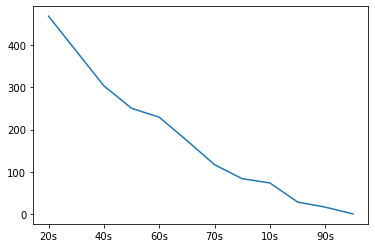

In [54]:
df['age'].value_counts().plot()

In [55]:
#Truncating 'n_age' value to decade value imputing it to 'age' column keeping the same format of 'age' given (i.e, '50s')
df['age'] = df['n_age'].apply(lambda x: '{}0s'.format(math.trunc(x/10)))

<AxesSubplot:>

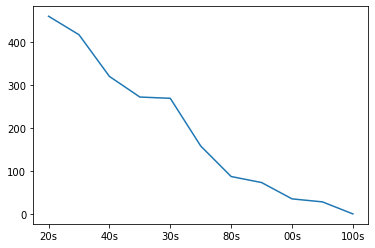

In [56]:
df['age'].value_counts().plot()

Differences in the count plots are not that significant, which give us a good insight on the imputation strategy made.

### `deceased_date`, `symptom_onset_date`, `released_date` and `confirmed_date` Column Analysis

Columns will be dropped shortly since small relevance is found in them and in most of all, 80% of their values are missing.

Check for any remaining null values

In [57]:
pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Missing'])

,Missing
deceased_date,2098
symptom_onset_date,1943
released_date,1907
confirmed_date,141
patient_id,0
infection_order,0
state,0
contact_number,0
infected_by,0
infection_case,0


In [58]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,1,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,58.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,1,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,35.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,2,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,58.0
3,1000000004,7.0,male,1991.0,30s,Korea,Seoul,Mapo-gu,0,1,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,31.0
4,1000000005,9.0,female,1992.0,30s,Korea,Seoul,Seongbuk-gu,0,2,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,30.0


Remove date columns from the data.


In [59]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

In [60]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,1,1.0,2.600789e+09,75.0,released,58.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,1,1.0,2.600789e+09,31.0,released,35.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,2,2.0,2.002000e+09,17.0,released,58.0
3,1000000004,7.0,male,1991.0,30s,Korea,Seoul,Mapo-gu,0,1,1.0,2.600789e+09,9.0,released,31.0
4,1000000005,9.0,female,1992.0,30s,Korea,Seoul,Seongbuk-gu,0,2,2.0,1.000000e+09,2.0,released,30.0


Review the count of unique values by column.

In [61]:
print(df.nunique())

patient_id         2130
global_num         1224
sex                   3
birth_year           97
age                  11
country               4
province             17
city                133
disease               2
infection_case       16
infection_order       7
infected_by         196
contact_number       73
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [62]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.574648
sex                0.001408
birth_year         0.045540
age                0.005164
country            0.001878
province           0.007981
city               0.062441
disease            0.000939
infection_case     0.007512
infection_order    0.003286
infected_by        0.092019
contact_number     0.034272
state              0.001408
n_age              0.045540
dtype: float64


Review the range of values per column.

In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2130.0,4.095989e+09,2.197921e+09,1.000000e+09,1.600000e+09,6.001000e+09,6.004000e+09,7.000000e+09
global_num,2130.0,4.526482e+03,2.137668e+03,1.000000e+00,4.051250e+03,4.664817e+03,5.445500e+03,8.717000e+03
birth_year,2130.0,1.974937e+03,1.728607e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
infection_case,2130.0,4.377465e+00,3.142200e+00,1.000000e+00,2.000000e+00,4.000000e+00,6.000000e+00,1.600000e+01
infection_order,2130.0,2.285714e+00,1.741536e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2130.0,2.620626e+09,7.269510e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2130.0,2.414551e+01,3.996888e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2130.0,4.642488e+01,1.972274e+01,2.000000e+00,2.825000e+01,4.600000e+01,6.000000e+01,1.060000e+02


### Check for duplicated rows

In [64]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [65]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

,VarName,LevelsCount
0,sex,3
1,age,11
2,country,4
3,province,17
4,city,133
5,disease,2
6,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

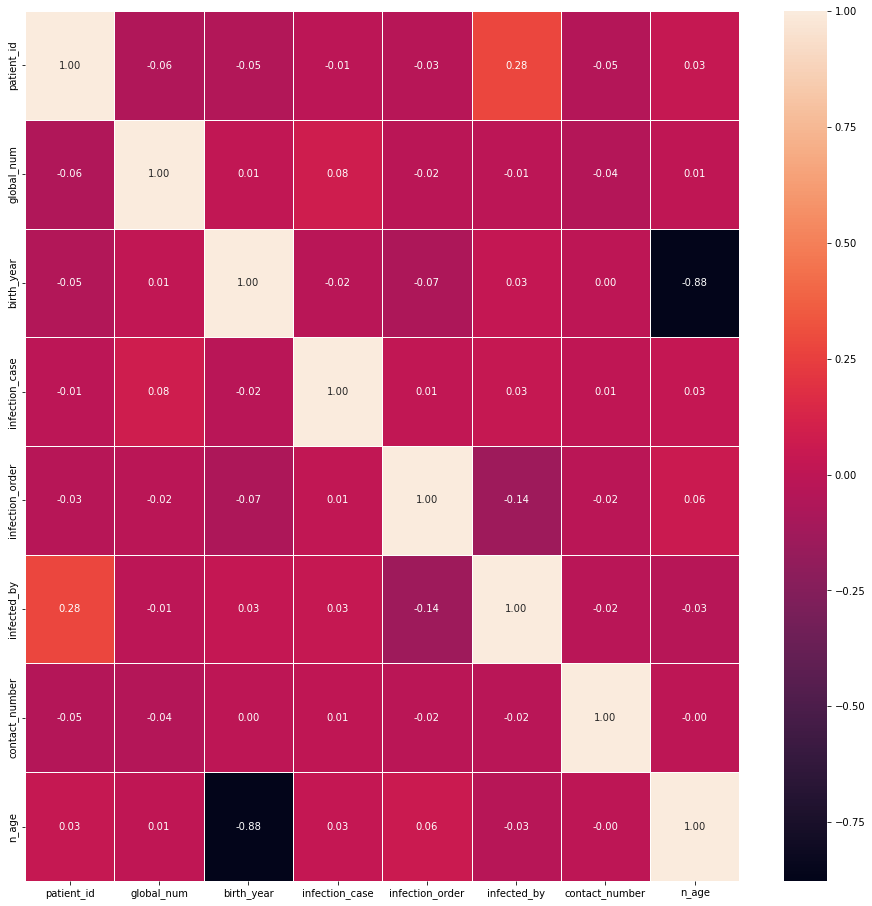

In [66]:
# Plotting correlation heatmap
plt.figure(figsize = (16,16))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f');

__Since Decision Trees or Random Forest are not sensible to colinearity, we can leave highlly correlated features to include them at the model.__

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

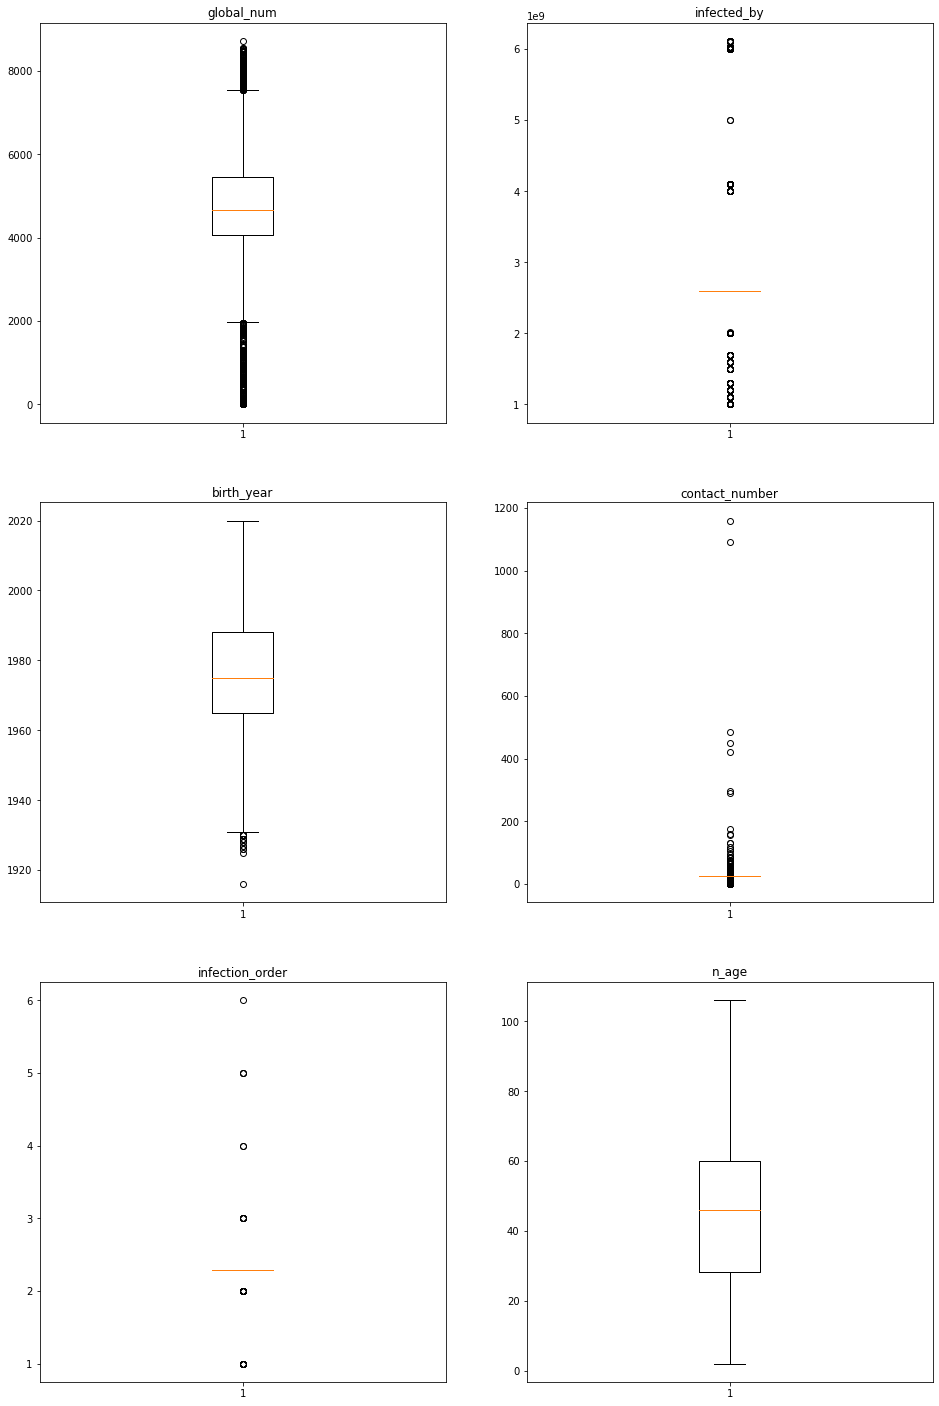

In [67]:
#Boxplot to check for outliers (only including numerical features)
# Initialise the subplot function using number of rows and columns
figure, ax = plt.subplots(3, 2, figsize=(16,25))
feats = ['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number', 'n_age']
r, c = 0, 0
for f in feats:
    ax[r,c].boxplot(df[f])
    ax[r,c].set_title(f)
    r += 1
    if r > 2:
        r = 0
        c = 1
plt.show()

**<font color='teal'> Create dummy features for object type features. </font>**

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130 entries, 0 to 2217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2130 non-null   int64  
 1   global_num       2130 non-null   float64
 2   sex              2130 non-null   object 
 3   birth_year       2130 non-null   float64
 4   age              2130 non-null   object 
 5   country          2130 non-null   object 
 6   province         2130 non-null   object 
 7   city             2130 non-null   object 
 8   disease          2130 non-null   object 
 9   infection_case   2130 non-null   int64  
 10  infection_order  2130 non-null   float64
 11  infected_by      2130 non-null   float64
 12  contact_number   2130 non-null   float64
 13  state            2130 non-null   object 
 14  n_age            2130 non-null   float64
dtypes: float64(6), int64(2), object(7)
memory usage: 330.8+ KB


In [69]:
X = pd.get_dummies(df.drop(columns=['state', 'patient_id']))
y = df[['state']]

C:\Users\pablo\.conda\envs\python38\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [70]:
X.columns

Index(['global_num', 'birth_year', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'n_age', 'sex_female', 'sex_male',
       'sex_unknown',
       ...
       'city_Yeonje-gu', 'city_Yeonsu-gu', 'city_Yeosu-si', 'city_Yongin-si',
       'city_Yongsan-gu', 'city_Yuseong-gu', 'city_etc', 'city_pocheon-si',
       'disease_0', 'disease_1'],
      dtype='object', length=177)

We dropped `state` column since it is the target feature and also we dropped `patient_id` feature since this has no relevance on the data case study (since it is a unique value on each petient with no sequence pattern).

In [71]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130 entries, 0 to 2217
Columns: 177 entries, global_num to disease_1
dtypes: float64(6), int64(1), uint8(170)
memory usage: 551.3 KB


In [72]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130 entries, 0 to 2217
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   state   2130 non-null   object
dtypes: object(1)
memory usage: 97.8+ KB


### Split the data into test and train subsamples

In [73]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [74]:
#scale data
from sklearn import preprocessing
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [75]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [76]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

C:\Users\pablo\AppData\Local\Temp/ipykernel_19228/614593206.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_res = clf.fit(X_train_scaled, y_train)


Random Forest: Accuracy=0.878
Random Forest: f1-score=0.858


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [77]:
#class_names=['isolated','released','missing','deceased'] # name  of classes
class_names=['isolated','released','deceased'] # name  of classes

__We did not included 'Missing'here since 'Missing' is not considered as a class. Model predicting as missing is not useful at all. Consider using 'missing' as a class when missing is a significant portion of the data (maybe try to do include them and see if this increases the performance of the model), but in this case, since missing value proportion is very small, we can get rid of them.__

Confusion matrix, without normalization
[[  6   1   0]
 [  0 354  11]
 [  0  40  14]]
Normalized confusion matrix
[[0.86 0.14 0.  ]
 [0.   0.97 0.03]
 [0.   0.74 0.26]]


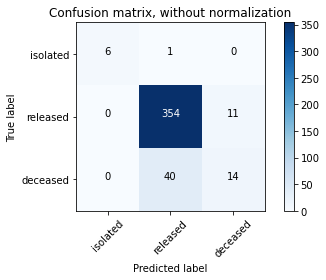

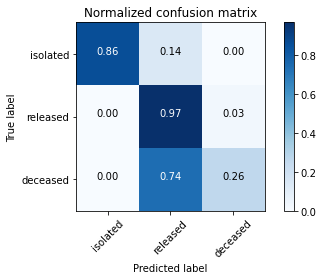

In [78]:
import itertools

from sklearn import svm, datasets

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


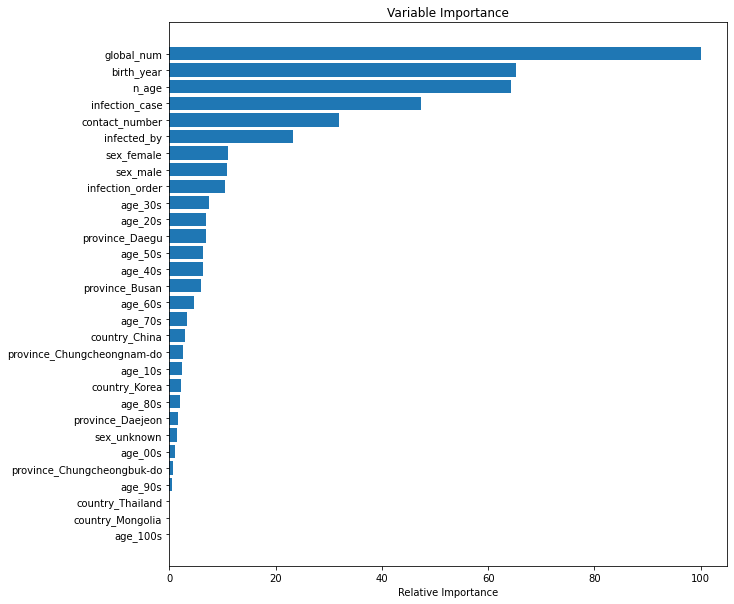

In [79]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.